In [ ]:
import os, zipfile
import datetime
import numpy as np
import tensorflow as tf

from google.colab import files
from keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


### Preparation Datasets

In [ ]:
# Download datasets
!wget --no-check-certificate \https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \-O /tmp/rockpaperscissors.zip

--2020-07-26 10:37:38--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.60MB/s    in 48s     

2020-07-26 10:38:28 (6.38 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
# Ekstraksi datasets
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# Set base directory
base_dir = '/tmp/rockpaperscissors/rps-cv-images'

#### Augmentasi Gambar

In [ ]:
# Augmentasi gambar yang nantinya dibuat 40% datasets masuk ke validation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#### Data Image Generator

Split gambar ke dalam training_generator dan validation_generator

In [ ]:
training_generator = datagen.flow_from_directory(
    base_dir,
    subset='training',
    shuffle=True,
    target_size=(150,150),
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    subset='validation',
    shuffle=True,
    target_size=(150,150),
    class_mode='categorical'
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [ ]:
# Untuk keperluang training dan evaluasi model
NUM_TRAINING_SAMPLES = training_generator.samples
NUM_VALIDATION_SAMPLES = validation_generator.samples
BATCH_SIZE = training_generator.batch_size

### Training dan Evaluasi Model

#### Pembuatan Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

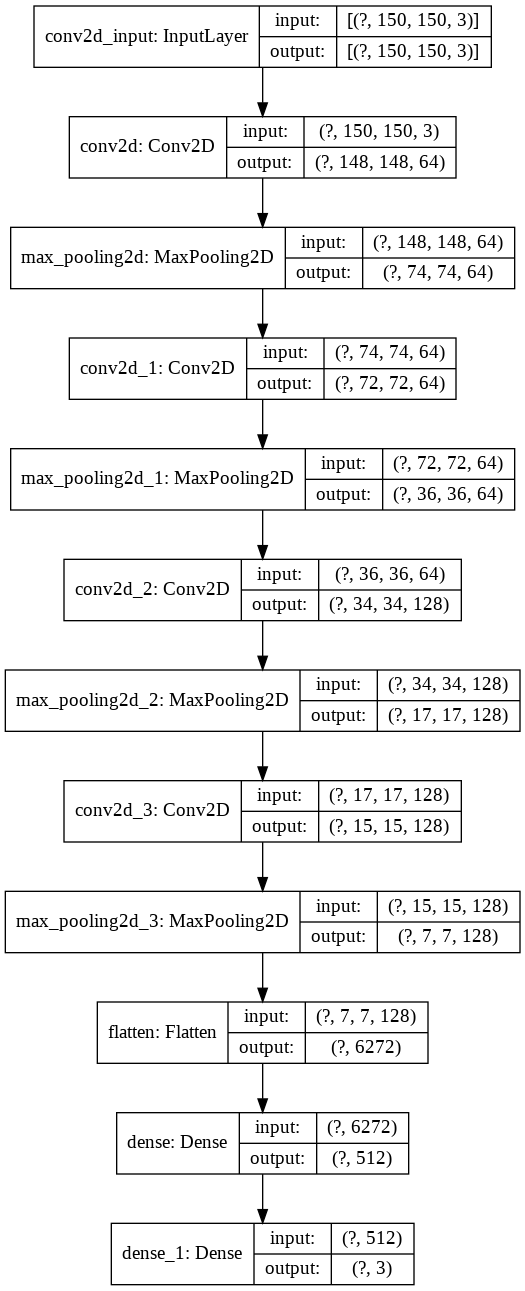

In [ ]:
model = tf.keras.models.Sequential([
    #1 convo
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #2 convo
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #3 convo
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #4 convo
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten
    tf.keras.layers.Flatten(),
    # Hidden layers
    tf.keras.layers.Dense(512, activation='relu'),
    # Output, softmax output > 1
    tf.keras.layers.Dense(3, activation='softmax')
])

# Cek Summary
model.summary()

# Melihat plot model
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
# Callback early stopping, 5x val_accuracy tdk ada perubahan, stop!
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
)

#### Compile dan Fit Model

In [ ]:
steps_per_epoch = NUM_TRAINING_SAMPLES // BATCH_SIZE
validation_steps = NUM_VALIDATION_SAMPLES // BATCH_SIZE
print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 41
validation_steps: 27


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

result = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        early_stopping_callback
    ],
    verbose=1
)

Epoch 1/15
41/41 [==============================] - 106s 3s/step - loss: 0.9936 - accuracy: 0.5265 - val_loss: 0.9171 - val_accuracy: 0.4850
Epoch 2/15
41/41 [==============================] - 105s 3s/step - loss: 0.6948 - accuracy: 0.7465 - val_loss: 0.5523 - val_accuracy: 0.8194
Epoch 3/15
41/41 [==============================] - 107s 3s/step - loss: 0.4877 - accuracy: 0.8292 - val_loss: 0.3881 - val_accuracy: 0.8738
Epoch 4/15
41/41 [==============================] - 106s 3s/step - loss: 0.3589 - accuracy: 0.8760 - val_loss: 0.3231 - val_accuracy: 0.9028
Epoch 5/15
41/41 [==============================] - 109s 3s/step - loss: 0.2757 - accuracy: 0.9087 - val_loss: 0.3885 - val_accuracy: 0.8275
Epoch 6/15
41/41 [==============================] - 107s 3s/step - loss: 0.2284 - accuracy: 0.9261 - val_loss: 0.1928 - val_accuracy: 0.9398
Epoch 7/15
41/41 [==============================] - 106s 3s/step - loss: 0.2241 - accuracy: 0.9150 - val_loss: 0.1910 - val_accuracy: 0.9433
Epoch 8/15
41

#### Evaluasi Model

In [ ]:
# Mengambil history dari loss dan accuracy
loss = result.history['loss']
val_loss = result.history['val_loss']
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

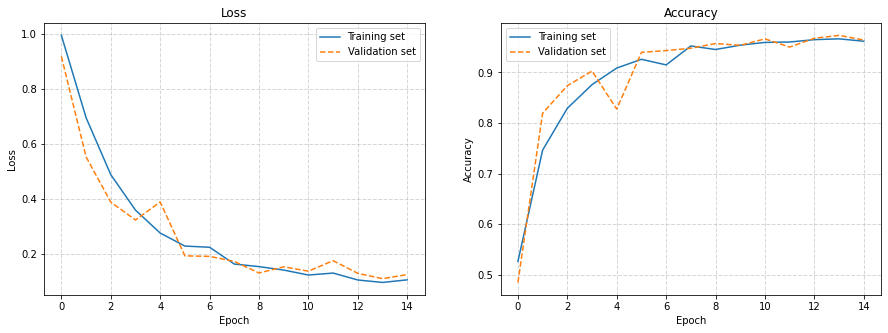

In [ ]:
# Menampilkan graph loss dan accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

In [ ]:
# Save model
# model.save('model__v1.h5')

### Prediksi Gambar

File images untuk testing saya upload di https://easyupload.io/qu4cof (30 days expired)

In [ ]:
def plot_predicts(data):
  n_rows = np.ceil(len(data) / 5) # menyusun 5 gambar per baris
  fig =plt.figure(figsize=(20, 5 * n_rows))
  n_columns = 5

  for i in range(0, len(data)):
    fig.add_subplot(n_rows, n_columns, i + 1)
    plt.title(data[i]['title'])
    plt.xlabel(data[i]['file'])
    plt.imshow(data[i]['img'])
  
  plt.show()

Saving scissors2.png to scissors2.png
Saving rock3.png to rock3.png
Saving scissors3.png to scissors3.png
Saving paper3.png to paper3.png
Saving rock2.png to rock2.png
Saving paper2.png to paper2.png
Saving paper1.png to paper1.png
Saving scissors1.png to scissors1.png
Saving rock1.png to rock1.png


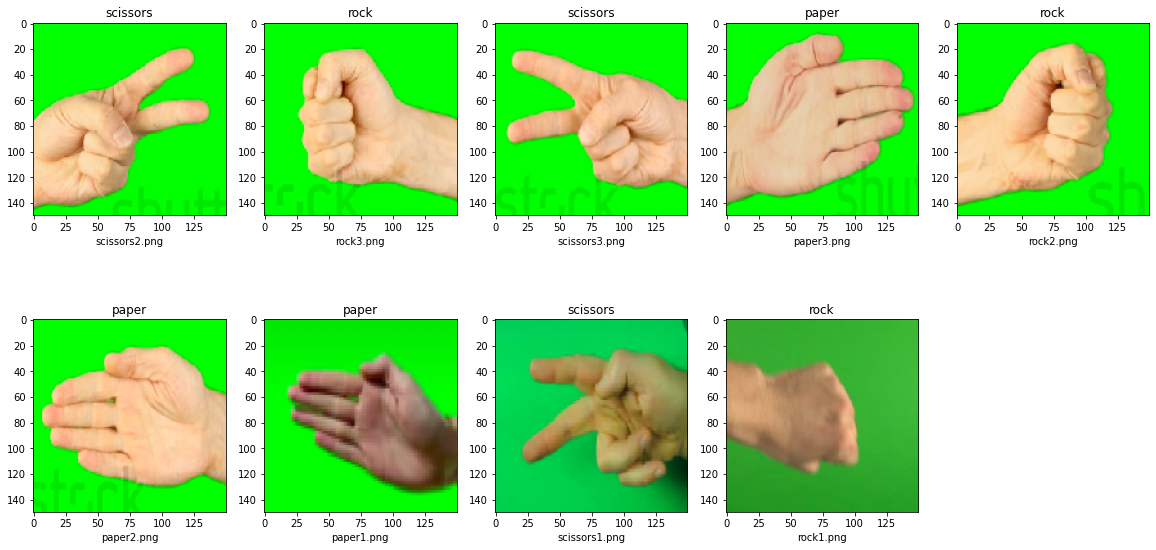

In [ ]:
uploaded = files.upload()

predicts = list()
for fn in uploaded.keys():

  predict = dict()
  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  predict['img'] = img
  predict['file'] = fn
  if classes[0][0] == 1:
    predict['title'] = 'paper'
  elif classes[0][1] == 1:
    predict['title'] = 'rock'
  else:
    predict['title'] = 'scissors'

  predicts.append(predict)

plot_predicts(predicts)